<a href="https://colab.research.google.com/github/StephWolter/PeterbestSellers/blob/main/Predicting_NYT_Lists.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [43]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Prevent Pandas from truncating DataFrames
pd.set_option('display.max_colwidth', None)

In [44]:
# Load data into pandas DataFrames
path = '/content/drive/MyDrive/GW/Project4_Model/nyt_data/' # EDIT ACCORDING TO YOUR PARTICULAR FILE STRUCTURE
results_df = pd.read_csv(path + 'results.csv')
lists_df = pd.read_csv(path + 'lists.csv')
books_df = pd.read_csv(path + 'books.csv', on_bad_lines='skip')

# Create a DataFrame containing both book and list (i.e., genre) information
books_lists = results_df[['list_id', 'book_id']].drop_duplicates()
bl_full = books_lists.merge(books_df, on='book_id')
bl_full.head()

,list_id,book_id,book_title,book_image,book_description,author_id,imprint_id
0,1,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/im...,In a quiet town on the North Carolina coast in...,1,1
1,3,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/im...,In a quiet town on the North Carolina coast in...,1,1
2,12,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/im...,In a quiet town on the North Carolina coast in...,1,1
3,5,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/im...,In a quiet town on the North Carolina coast in...,1,1
4,18,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/im...,In a quiet town on the North Carolina coast in...,1,1


In [45]:
# Review the list DataFrame in order to determine which lists are fiction and which are nonfiction
lists_df

,list_id,list_name
0,1,Combined Print and E-Book Fiction
1,2,Combined Print and E-Book Nonfiction
2,3,Hardcover Fiction
3,4,Hardcover Nonfiction
4,5,Trade Fiction Paperback
5,6,Paperback Nonfiction
6,7,Advice How-To and Miscellaneous
7,8,Childrens Middle Grade Hardcover
8,9,Picture Books
9,10,Series Books


In [46]:
# Create an array of list_id's that are fiction and another array of list_id's that are nonfiction
fiction_ids = [
    1,
    3,
    5,
    8,
    9,
    10,
    11,
    12,
    17,
    18,
    19,
    20,
    21,
    22,
    24,
    25,
    26,
    27,
    28,
    29,
    30,
    42,
    47,
    50,
    51,
    56,
    58,
    59
]
nonfiction_ids = [id for id in lists_df['list_id'] if id not in fiction_ids]

In [47]:
# Define a function that assigns a value of 1 to books on a fiction list and a value of 0 to books on a nonfiction list
def is_fiction(value):
  if value in fiction_ids:
    return 1
  else:
    return 0

# Use .map() to add the column, is_fiction, to the DataFrame
bl_full['is_fiction'] = bl_full['list_id'].map(is_fiction)
bl_full.head()

,list_id,book_id,book_title,book_image,book_description,author_id,imprint_id,is_fiction
0,1,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/im...,In a quiet town on the North Carolina coast in...,1,1,1
1,3,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/im...,In a quiet town on the North Carolina coast in...,1,1,1
2,12,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/im...,In a quiet town on the North Carolina coast in...,1,1,1
3,5,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/im...,In a quiet town on the North Carolina coast in...,1,1,1
4,18,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/im...,In a quiet town on the North Carolina coast in...,1,1,1


In [48]:
# Add a column, title_desc, which is simply a concatenation of the book title and the book description
bl_full['title_desc'] = bl_full['book_title'] + " " + bl_full['book_description']
bl_full.head()

,list_id,book_id,book_title,book_image,book_description,author_id,imprint_id,is_fiction,title_desc
0,1,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/im...,In a quiet town on the North Carolina coast in...,1,1,1,WHERE THE CRAWDADS SING In a quiet town on the...
1,3,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/im...,In a quiet town on the North Carolina coast in...,1,1,1,WHERE THE CRAWDADS SING In a quiet town on the...
2,12,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/im...,In a quiet town on the North Carolina coast in...,1,1,1,WHERE THE CRAWDADS SING In a quiet town on the...
3,5,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/im...,In a quiet town on the North Carolina coast in...,1,1,1,WHERE THE CRAWDADS SING In a quiet town on the...
4,18,1,WHERE THE CRAWDADS SING,https://storage.googleapis.com/du-prd/books/im...,In a quiet town on the North Carolina coast in...,1,1,1,WHERE THE CRAWDADS SING In a quiet town on the...


In [49]:
# Create a new DataFrame, df, that pulls the title_desc and is_fiction columns from bl_full
df = bl_full[['title_desc', 'is_fiction']]

# Drop duplicates and NaN's
df = df.drop_duplicates()
df = df.dropna()
df.head()

,title_desc,is_fiction
0,WHERE THE CRAWDADS SING In a quiet town on the...,1
5,THE SAVIOR The 17th book in the Black Dagger B...,1
7,A GENTLEMAN IN MOSCOW A Russian count undergoe...,1
10,SUPERMARKET A depressed young man’s secrets ar...,1
12,THE CORNWALLS ARE GONE An Army intelligence of...,1


In [50]:
# Use regex to remove punctuation from the title_desc strings
desc_text = df['title_desc'].astype(str).str.replace('[^\w\s]','')

<ipython-input-50-d4d83208094a>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  desc_text = df['title_desc'].astype(str).str.replace('[^\w\s]','')


In [51]:
# Tokenize the text. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace)
# See https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(desc_text)
X_text = tokenizer.texts_to_sequences(desc_text)

# Pad sequences to a fixed length of 350, adding 0s if the text is less than 350 characters, and truncating the text if it is greater than 350 characters
max_sequence_length = 350
desc_text_padded = pad_sequences(X_text, maxlen=max_sequence_length, padding='post')
X_text_padded = desc_text_padded

In [52]:
# Target array
y = df['is_fiction']

In [53]:
# Split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_text_padded, y, random_state=42)

## **First Model Iteration**

In [95]:
# Create an empty sequential model
model1 = tf.keras.models.Sequential()

# First layer
model1.add(tf.keras.layers.Dense(units=200, activation='relu', input_dim=X_train.shape[1]))

# Hidden layer
model1.add(tf.keras.layers.Dense(units=32, activation='relu'))

# Output layer
model1.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Model summary
model1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 200)               70200     
                                                                 
 dense_13 (Dense)            (None, 32)                6432      
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 76,665
Trainable params: 76,665
Non-trainable params: 0
_________________________________________________________________


In [96]:
# Compile and train the model
model1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history1 = model1.fit(X_train, y_train, epochs=15)

Epoch 1/15
253/253 [==============================] - 2s 3ms/step - loss: 30.5350 - accuracy: 0.6041
Epoch 2/15
253/253 [==============================] - 1s 3ms/step - loss: 0.7119 - accuracy: 0.6641
Epoch 3/15
253/253 [==============================] - 1s 3ms/step - loss: 0.6528 - accuracy: 0.6656
Epoch 4/15
253/253 [==============================] - 1s 3ms/step - loss: 0.6430 - accuracy: 0.6660
Epoch 5/15
253/253 [==============================] - 1s 3ms/step - loss: 0.6368 - accuracy: 0.6670
Epoch 6/15
253/253 [==============================] - 1s 3ms/step - loss: 0.6339 - accuracy: 0.6668
Epoch 7/15
253/253 [==============================] - 1s 5ms/step - loss: 0.6323 - accuracy: 0.6670
Epoch 8/15
253/253 [==============================] - 1s 5ms/step - loss: 0.6312 - accuracy: 0.6669
Epoch 9/15
253/253 [==============================] - 1s 5ms/step - loss: 0.6308 - accuracy: 0.6675
Epoch 10/15
253/253 [==============================] - 1s 5ms/step - loss: 0.6307 - accuracy: 0.667

In [97]:
# Display predictive accuracy on test data
model_loss, model_accuracy = model1.evaluate(X_test, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

85/85 - 0s - loss: 0.6604 - accuracy: 0.6705 - 288ms/epoch - 3ms/step
Loss: 0.6603760719299316, Accuracy: 0.6705094575881958


In [98]:
# Save the outputs from the model training
history1_dict = history1.history
loss1 = history1_dict['loss']
acc1 = history1_dict['accuracy']
epochs = range(1, len(loss1) + 1)

# **Second Model Iteration**

In [112]:
# Create an empty sequential model
model2 = tf.keras.models.Sequential()

# Add an Embedding layer to take the integer-encoded title_descs and look up an embedding vector for each word-index
# Adapted from https://www.tensorflow.org/tutorials/keras/text_classification
model2.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=max_sequence_length))

# Add a Dropout layer to randomly set 0.2 of the input units to 0 at each step during training time. This helps prevent overfitting
# See https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout
model2.add(tf.keras.layers.Dropout(0.2))

# Add a Global Average Pooling layer to return a fixed-length output vector for each example by averaging over the sequence dimension
model2.add(tf.keras.layers.GlobalAveragePooling1D())

# Hidden layer
model2.add(tf.keras.layers.Dense(units=32, activation='relu'))

# Output layer
model2.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Model summary
model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 350, 100)          2103700   
                                                                 
 dropout_4 (Dropout)         (None, 350, 100)          0         
                                                                 
 global_average_pooling1d_4   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_17 (Dense)            (None, 32)                3232      
                                                                 
 dense_18 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,106,965
Trainable params: 2,106,965
Non-trainable params: 0
____________________________________________

In [113]:
# Compile and train the model
model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history2 = model2.fit(X_train, y_train, epochs=15)

Epoch 1/15
253/253 [==============================] - 15s 57ms/step - loss: 0.6375 - accuracy: 0.6659
Epoch 2/15
253/253 [==============================] - 17s 67ms/step - loss: 0.6172 - accuracy: 0.6662
Epoch 3/15
253/253 [==============================] - 14s 56ms/step - loss: 0.5199 - accuracy: 0.6818
Epoch 4/15
253/253 [==============================] - 15s 58ms/step - loss: 0.3789 - accuracy: 0.8473
Epoch 5/15
253/253 [==============================] - 13s 53ms/step - loss: 0.2779 - accuracy: 0.9026
Epoch 6/15
253/253 [==============================] - 15s 58ms/step - loss: 0.2337 - accuracy: 0.9171
Epoch 7/15
253/253 [==============================] - 14s 57ms/step - loss: 0.2008 - accuracy: 0.9290
Epoch 8/15
253/253 [==============================] - 15s 59ms/step - loss: 0.1789 - accuracy: 0.9406
Epoch 9/15
253/253 [==============================] - 15s 59ms/step - loss: 0.1654 - accuracy: 0.9415
Epoch 10/15
253/253 [==============================] - 15s 61ms/step - loss: 0.150

In [114]:
# Display predictive accuracy on test data
model_loss, model_accuracy = model2.evaluate(X_test, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

85/85 - 0s - loss: 0.3292 - accuracy: 0.8765 - 423ms/epoch - 5ms/step
Loss: 0.32924386858940125, Accuracy: 0.8765340447425842


In [102]:
# Save the outputs from the model training
history2_dict = history2.history
loss2 = history2_dict['loss']
acc2 = history2_dict['accuracy']

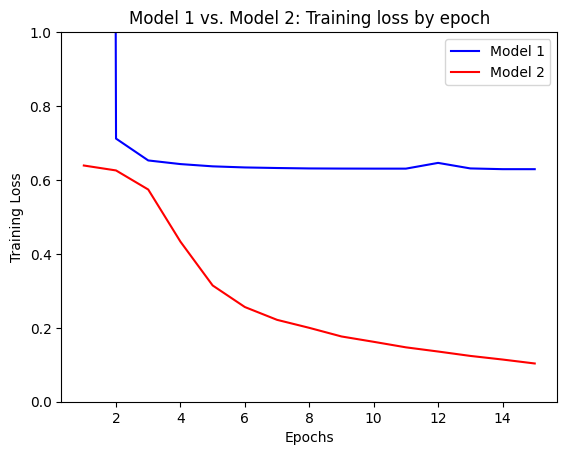

In [108]:
# Plot loss history for each model
plt.plot(epochs, loss1, 'b', label='Model 1')
plt.plot(epochs, loss2, 'r', label='Model 2')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Model 1 vs. Model 2: Training loss by epoch')
plt.ylim(0, 1)
plt.legend()
plt.show()

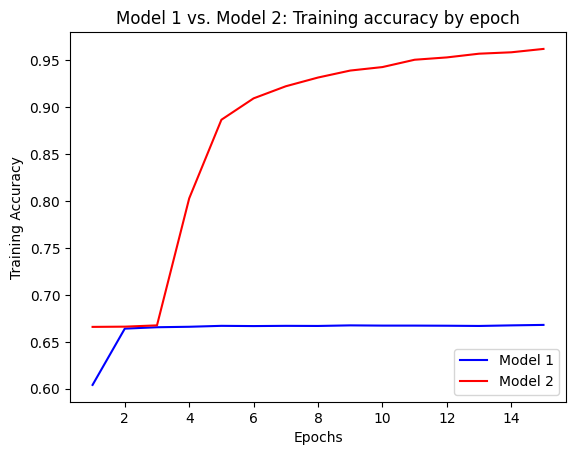

In [109]:
# Plot accuracy history for each model
plt.plot(epochs, acc1, 'b', label='Model 1')
plt.plot(epochs, acc2, 'r', label='Model 2')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Model 1 vs. Model 2: Training accuracy by epoch')
plt.legend(loc='lower right')
plt.show()

# **Predictions**

In [90]:
# Define a tokenization function to facilitate the processing of raw strings
def tokenize_text(sequences):
  for sequence in sequences:
    for dtext in sequence:
      dtext = dtext.replace('[^\w\s]','')

  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(sequences)
  X_text = tokenizer.texts_to_sequences(sequences)

  max_sequence_length = 350
  desc_text_padded = pad_sequences(X_text, maxlen=max_sequence_length, padding='post')
  return desc_text_padded

In [93]:
# Examples of raw strings to pass to the model for predictions
descs = [
    'Ready Player One. In 2045 the planet is on the brink of chaos and collapse but people find salvation in the OASIS: an expansive virtual reality universe created by eccentric James Halliday.',
    'Coins of Change. A historical and cultural examination of technological innovation in Western societies.']

X = tokenize_text(descs)

In [94]:
# Get predictions for examples
model2.predict(X)

1/1 [==============================] - 0s 37ms/step


array([[0.99889946],
       [0.53872824]], dtype=float32)